In [22]:
# 1. Importação de Bibliotecas e Preparação do Ambiente

import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import json
import string

# Download de recursos da NLTK (necessário apenas na primeira execução)
try:
    stopwords.words('english')
except LookupError:
    nltk.download('stopwords')

In [25]:
jsonCarregado = []
decoder = json.JSONDecoder()
with open(r'/content/json_unificado.json', 'r') as file_object:
    file_content = file_object.read()

file_content = file_content.strip()

indice = 0

while indice < len(file_content):
  try:
    obj, indice_final = decoder.raw_decode(file_content[indice:])

    jsonCarregado.append(obj)

    indice += indice_final

    while indice < len(file_content) and file_content[indice].isspace():
      indice +=1
  except json.JSONDecodeError:
    break

def extract_strings(obj):
    if isinstance(obj, str):
        yield obj
    elif isinstance(obj, dict):
        for v in obj.values():
            yield from extract_strings(v)
    elif isinstance(obj, list):
        for item in obj:
            yield from extract_strings(item)

# Turn into a list (corpus)
corpusAux = list(extract_strings(jsonCarregado))

corpus_sem_pontuacao = [
    s.translate(str.maketrans("", "", string.punctuation))
    for s in corpusAux
]

corpus = []
for s in corpus_sem_pontuacao:
    string_limpa = s.strip()
    if string_limpa:  # Verifica se a string não está vazia após a remoção de espaços
        corpus.append(string_limpa)

if not corpus:
    print("O corpus está vazio.")
else:
    print("Corpus carregado com sucesso!")
    stemmer = PorterStemmer()
    english_stop_words_original = set(stopwords.words('english'))
    english_stop_words_original.update(string.punctuation)



    stop_words_stemmed = []
    for word in english_stop_words_original:
      palavra_processada = stemmer.stem(word)
      stop_words_stemmed.append(palavra_processada)


    def stem_tokenizer(text):
      tokens = text.split()
      stemmed_tokens = [stemmer.stem(token) for token in tokens]
      return stemmed_tokens

    bow_vec = CountVectorizer(
    lowercase=True,
    stop_words=stop_words_stemmed,  # Usa a lista de stopwords corrigida
    tokenizer=stem_tokenizer
    )

    try:
      X_bow = bow_vec.fit_transform(corpus_sem_pontuacao)
      df_bow = pd.DataFrame(X_bow.toarray(), columns=bow_vec.get_feature_names_out())
      print("Matriz Documento-Termo (BoW):")
      print(df_bow)
    except ValueError as e:
        print(f"Erro ao criar o BoW: {e}")
        print("Isso pode acontecer se o corpus contiver apenas stop words.")
        print(f"Amostra do corpus processado: {corpus[:5]}")

Corpus carregado com sucesso!
Matriz Documento-Termo (BoW):
     0  1  10  100  10th  10thlevel  10yearold  11th  12  120  ...  yelp  yet  \
0    0  0   0    0     0          0          0     0   0    0  ...     0    0   
1    0  0   0    0     0          0          0     0   1    0  ...     0    0   
2    0  0   0    0     0          0          0     0   0    0  ...     0    0   
3    0  0   0    0     0          0          0     0   0    0  ...     0    0   
4    0  0   0    0     0          0          0     0   0    0  ...     0    0   
..  .. ..  ..  ...   ...        ...        ...   ...  ..  ...  ...   ...  ...   
900  0  0   0    0     0          0          0     0   0    0  ...     0    0   
901  0  0   0    0     0          0          0     0   0    0  ...     0    0   
902  0  0   0    0     0          0          0     0   0    0  ...     0    0   
903  0  1   0    0     0          0          0     0   0    0  ...     0    0   
904  0  0   0    0     0          0          0   

In [30]:
tfidf_vec = TfidfVectorizer(
    lowercase=True,
    stop_words=stop_words_stemmed, # Usa a lista de stopwords corrigida
    tokenizer=stem_tokenizer
)
X_tfidf = tfidf_vec.fit_transform(corpus)
df_tfidf = pd.DataFrame(X_tfidf.toarray(), columns=tfidf_vec.get_feature_names_out())

print("Matriz Documento-Termo (TF-IDF):")
df_tfidf.round(3)

/usr/local/lib/python3.12/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/feature_extraction/text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['becau'] not in stop_words.
  warnings.warn(


Matriz Documento-Termo (TF-IDF):


,0,1,10,100,10th,10thlevel,10yearold,11th,12,120,...,yelp,yet,yew,young,youngest,youv,you’r,zarovich,–,•
0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.211,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
900,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
901,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
902,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
903,0.0,0.268,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [31]:
def search_and_rank(query, vectorizer, X_corpus, corpus, method_name):
    """
    Vetoriza uma query, calcula a similaridade com o corpus e exibe os resultados.
    """
    q_vec = vectorizer.transform([query])
    sim_scores = cosine_similarity(q_vec, X_corpus).ravel()
    rank = np.argsort(sim_scores)[::-1]

    print(f"Top-3 Similares para a Query (usando {method_name}):")
    for i in rank[:3]:
        if sim_scores[i] > 0.01: # Apenas mostra se houver alguma similaridade
            print(f"  Doc{i+1} (score={sim_scores[i]:.3f}): {corpus[i]}")
    print("-" * 40)

query = 'I am a dwarf and im digging a hole'
print(f">> Executando busca para a query: '{query}'\n")
search_and_rank(query, bow_vec, X_bow, corpus, "BoW")
search_and_rank(query, tfidf_vec, X_tfidf, corpus, "TF-IDF")

>> Executando busca para a query: 'I am a dwarf and im digging a hole'

Top-3 Similares para a Query (usando BoW):
  Doc763 (score=0.707): Hill Dwarf
  Doc767 (score=0.707): Mountain Dwarf
  Doc768 (score=0.320): As a mountain dwarf youre strong and hardy accustomed to a difficult life in rugged terrain Youre probably on the tall side for a dwarf and tend toward lighter coloration The shield dwarves of northern Faerun as well as the ruling Hylar clan and the noble Daewar clan of Dragonlance are mountain dwarves
----------------------------------------
Top-3 Similares para a Query (usando TF-IDF):
  Doc767 (score=0.696): Mountain Dwarf
  Doc763 (score=0.668): Hill Dwarf
  Doc768 (score=0.309): As a mountain dwarf youre strong and hardy accustomed to a difficult life in rugged terrain Youre probably on the tall side for a dwarf and tend toward lighter coloration The shield dwarves of northern Faerun as well as the ruling Hylar clan and the noble Daewar clan of Dragonlance are mountain dw

Calculando a matriz de similaridade de cossenos...


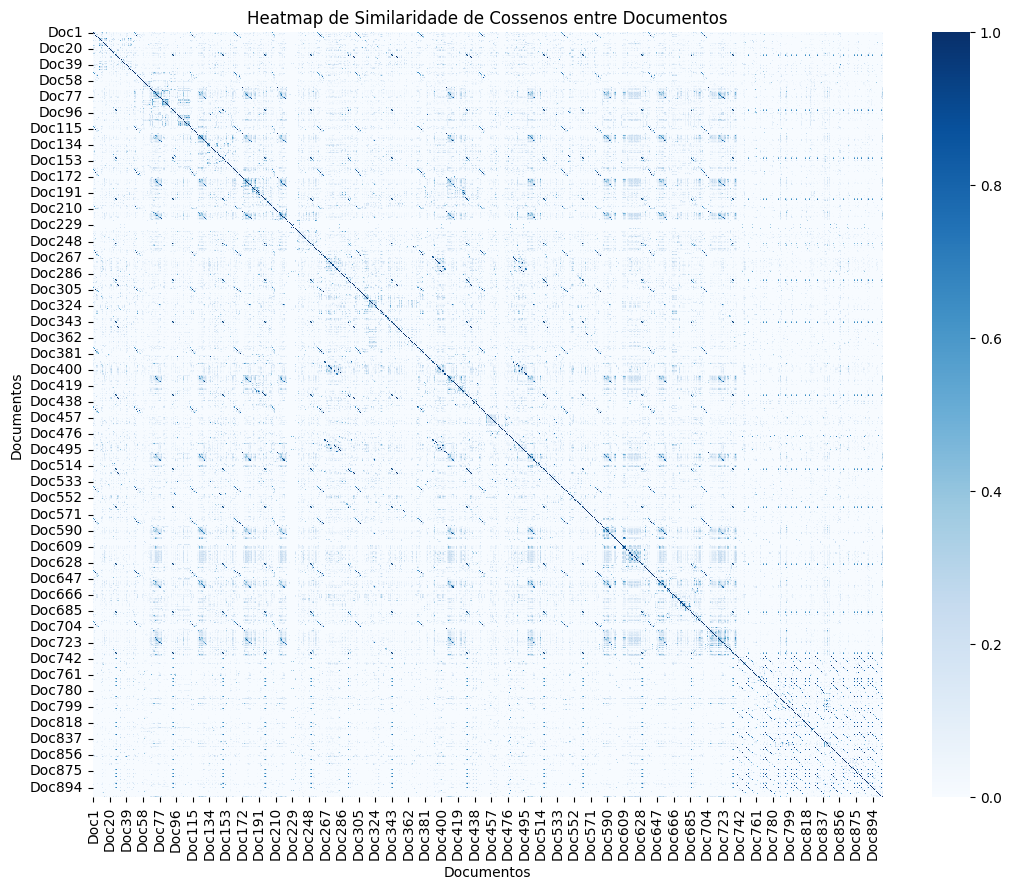

In [32]:
# 7. Visualizações

# a) Heatmap da Similaridade de Cossenos entre Documentos
# Primeiro, calculamos a matriz de similaridade (documento x documento) usando a matriz TF-IDF
print("Calculando a matriz de similaridade de cossenos...")
sim_matrix = cosine_similarity(X_tfidf, X_tfidf)

# Para melhor visualização, criamos um DataFrame com os rótulos corretos
doc_labels = [f"Doc{i+1}" for i in range(len(corpus))]
df_similarity = pd.DataFrame(sim_matrix, index=doc_labels, columns=doc_labels)

# Agora, geramos o heatmap a partir dessa matriz de similaridade
plt.figure(figsize=(11, 9))
sns.heatmap(
    df_similarity,
    #annot=True,          # Exibe os valores de similaridade nas células
    cmap="Blues",        # Mapa de cores em tons de azul
    fmt=".2f"            # Formata os números com duas casas decimais
)
plt.title("Heatmap de Similaridade de Cossenos entre Documentos")
plt.xlabel("Documentos")
plt.ylabel("Documentos")
plt.tight_layout()
plt.show()

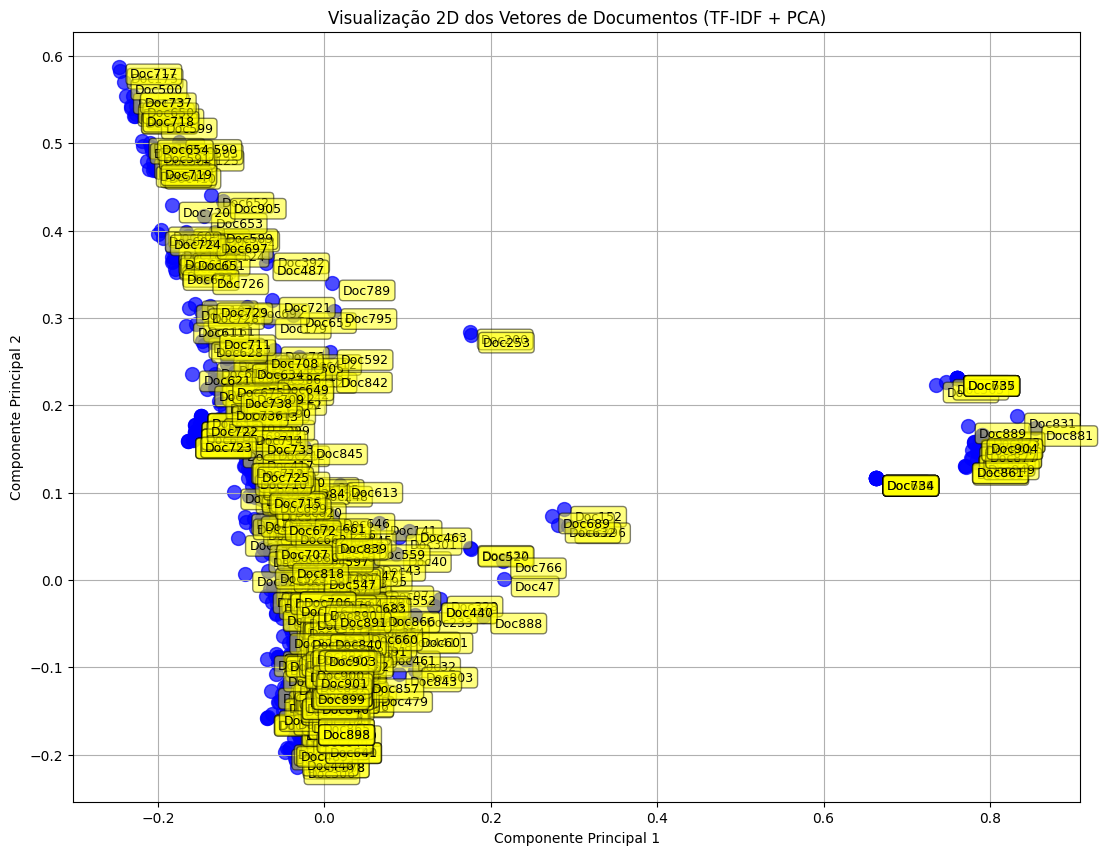

In [33]:
# b) Visualização dos Documentos em 2D com PCA
pca = PCA(n_components=2)
# Usamos .toarray() para converter a matriz esparsa para uma matriz densa
X_tfidf_pca = pca.fit_transform(X_tfidf.toarray())

plt.figure(figsize=(13, 10))
plt.scatter(X_tfidf_pca[:, 0], X_tfidf_pca[:, 1], c='blue', alpha=0.7, s=100)
plt.title("Visualização 2D dos Vetores de Documentos (TF-IDF + PCA)")
plt.xlabel("Componente Principal 1")
plt.ylabel("Componente Principal 2")
plt.grid(True)


# Adiciona anotações para cada ponto
for i, _ in enumerate(corpus_sem_pontuacao):
    plt.annotate(f"Doc{i+1}", (X_tfidf_pca[i, 0], X_tfidf_pca[i, 1]),
                 xytext=(8, -8), textcoords='offset points', fontsize=9,
                 bbox=dict(boxstyle="round,pad=0.3", fc="yellow", alpha=0.5))
plt.show()